In [1]:
# Import libraries

from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Lambda,Dense,BatchNormalization,Dropout, Activation,GRU,SimpleRNN
from tensorflow.keras.regularizers import l2
import keras.backend as K
from tensorflow import keras
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ultimatedude/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Preparation
First we need to do some preparation: some of our models require the sentences to be tokenized, some do not. For that reason we'll make a simple Sentence class where we keep both the raw sentence and the tokenized sentence. The individual methods below will then pick the input they need.

In [ ]:
stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

# Ultimate Session

In [5]:
import numpy as np
np.random.seed(0)

In [6]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


In [7]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.200d.txt')

Lets test it now with a word 'cucumber'

In [8]:
word = "alice"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of alice in the vocabulary is 51353
the 289846th word in the vocabulary is potatos


In [9]:
inverse_vocabulary = ['<unk>'] 
tokenizer = nltk.tokenize.TreebankWordTokenizer()
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m,max_len))
    #print(X1_indices)
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words =tokenizer.tokenize(X[i])
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            try:
              X_indices[i, j] = word_to_index[w]
            except:
              continue
            # Increment j to j + 1
            j = j + 1
            
    ### END CODE HERE ###
    
    return X_indices

In [10]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


Lets tests this function

X1 = np.array(['open youtube for me', 'can you open youtube for me',
       'i want to visit youtube'])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 12)
print("X1 =", X1)

print("X1_indices =\n", X1_indices)
X1.shape

In [11]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    # See instructions above to choose the correct shape.
    emb_matrix = np.zeros((vocab_len,emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = tf.keras.layers.Embedding(vocab_len,emb_dim,trainable = False)
    

    # Step 4 (already done for you; please do not modify)
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

Lets test this function

In [12]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.11844


In [13]:
# def convert_to_one_hot(Y, C):
#     Y = np.eye(C)[Y.reshape(-1)]
#     return Y

**Read the data**

In [14]:
import csv
def read_csv(filename = '/content/train_command.csv'):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y


In [15]:
X_train, Y_train = read_csv('train_command.csv')
X_test, Y_test= read_csv('validation command.csv')

In [16]:
for command in X_train:
  text_to_word_list(command)

In [17]:
maxLen = len(max(X_train, key=len).split())

In [18]:
#print(maxLen)
# hard coding max len
maxLen = 15

## Model

In [20]:
pip install -q tensorflow-model-optimization

     |████████████████████████████████| 215kB 8.3MB/s 


In [21]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
import keras
import keras.backend as K
import tempfile

In [19]:
### LSTM Model###
def similarity_model(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = tf.keras.layers.Input(input_shape,dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map,word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    # (See additional hints in the instructions).
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = tf.keras.layers.LSTM(128,return_sequences =True, name = 'hidden1')(embeddings)
    X = tf.keras.layers.BatchNormalization()(X)
    # Add dropout with a probability of 0.5
    X = tf.keras.layers.Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = tf.keras.layers.LSTM(128,return_sequences = True)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    # Add dropout with a probability of 0.5
    X = tf.keras.layers.Dropout(0.5)(X)
    # X = LSTM(128,return_sequences = True,activity_regularizer= l2(0.03))(X)
    # X = BatchNormalization()(X)
    # X = Dropout(0.5)(X)
    X = tf.keras.layers.LSTM(64,return_sequences = False)(X)
    #X = Flatten()(X)
    # Propagate X through a Dense layer with 5 units
    X = tf.keras.layers.Dense(units=23)(X)
    # Add a softmax activation
    X = tf.keras.layers.Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = tf.keras.models.Model(sentence_indices,X)
    
    ### END CODE HERE ###
    
    return model

In [31]:
### GRU Model###
def similarity_model_GRU(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = tf.keras.layers.Input(input_shape,dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map,word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    # (See additional hints in the instructions).
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = tf.keras.layers.GRU(128,return_sequences =True, name = 'hidden1')(embeddings)
    X = tf.keras.layers.BatchNormalization()(X)
    # Add dropout with a probability of 0.5
    X = tf.keras.layers.Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = tf.keras.layers.GRU(128,return_sequences = True)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    # Add dropout with a probability of 0.5
    X = tf.keras.layers.Dropout(0.5)(X)
    # X = LSTM(128,return_sequences = True,activity_regularizer= l2(0.03))(X)
    # X = BatchNormalization()(X)
    # X = Dropout(0.5)(X)
    X = tf.keras.layers.GRU(64,return_sequences = False)(X)
    #X = Flatten()(X)
    # Propagate X through a Dense layer with 5 units
    X = tf.keras.layers.Dense(units=23)(X)
    # Add a softmax activation
    X = tf.keras.layers.Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = tf.keras.models.Model(sentence_indices,X)
    
    ### END CODE HERE ###
    
    return model

In [32]:
### SimpleRNN Model###
def similarity_model_SimpleRNN(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = tf.keras.layers.Input(input_shape,dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map,word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    # (See additional hints in the instructions).
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = tf.keras.layers.SimpleRNN(128,return_sequences =True, name = 'hidden1', use_bias = True)(embeddings)
    X = tf.keras.layers.BatchNormalization()(X)
    # Add dropout with a probability of 0.5
    X = tf.keras.layers.Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = tf.keras.layers.SimpleRNN(128,return_sequences = True, use_bias = True)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    # Add dropout with a probability of 0.5
    X = tf.keras.layers.Dropout(0.5)(X)
    # X = LSTM(128,return_sequences = True,activity_regularizer= l2(0.03))(X)
    # X = BatchNormalization()(X)
    # X = Dropout(0.5)(X)
    X = tf.keras.layers.SimpleRNN(64,return_sequences = False)(X)
    #X = Flatten()(X)
    # Propagate X through a Dense layer with 5 units
    X = tf.keras.layers.Dense(units=23)(X)
    # Add a softmax activation
    X = tf.keras.layers.Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = tf.keras.models.Model(sentence_indices,X)
    
    ### END CODE HERE ###
    
    return model

In [33]:
model_gru = similarity_model_GRU((maxLen,), word_to_vec_map, word_to_index) 
model_gru.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 15, 200)           80000200  
_________________________________________________________________
hidden1 (GRU)                (None, 15, 128)           126720    
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 128)           512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
gru (GRU)                    (None, 15, 128)           99072     
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 128)           512 

In [34]:
model_RNN = similarity_model_SimpleRNN((maxLen,), word_to_vec_map, word_to_index)
model_RNN.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 15, 200)           80000200  
_________________________________________________________________
hidden1 (SimpleRNN)          (None, 15, 128)           42112     
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 128)           512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 15, 128)           32896     
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 128)           512 

In [20]:
model = similarity_model((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 15, 200)           80000200  
_________________________________________________________________
hidden1 (LSTM)               (None, 15, 128)           168448    
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 128)           512       
_________________________________________________________________
dropout (Dropout)            (None, 15, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 15, 128)           131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 128)           512   

In [53]:
# Optimizer
# optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001, clipnorm=1.26)

In [35]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)


In [36]:
import tensorflow as tf
Y_train_oh = tf.keras.utils.to_categorical(Y_train,num_classes = 23)

In [37]:
# Now test the model
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
Y_test_oh = tf.keras.utils.to_categorical(Y_test,num_classes = 23)

#### LSTM Training

In [21]:
model.load_weights('command_iden_model_final.h5')

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_indices, Y_train_oh, epochs = 150, batch_size = 25, shuffle=True,validation_data=(X_test_indices, Y_test_oh))

In [27]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


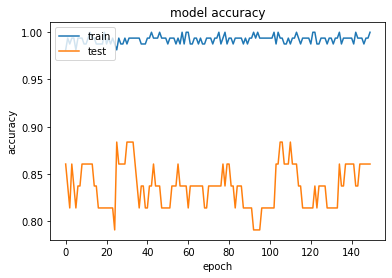

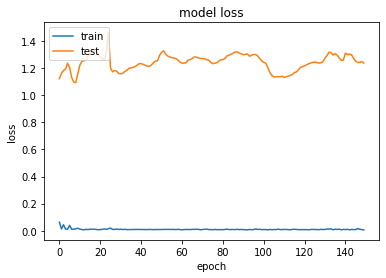

In [28]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 0s 31ms/step - loss: 1.2361 - accuracy: 0.8605

Test accuracy =  0.8604651093482971


In [ ]:
model.save('command_iden_model_final.h5')
# 309mb 

#### GRU Training

In [39]:
model_gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
gru_history = model_gru.fit(X_train_indices, Y_train_oh, epochs = 300, batch_size = 25, shuffle=True,validation_data=(X_test_indices, Y_test_oh))
model_gru.reset_states()

Epoch 1/300
7/7 [==============================] - 1s 114ms/step - loss: 1.7143 - accuracy: 0.5342 - val_loss: 2.8743 - val_accuracy: 0.3488
Epoch 2/300
7/7 [==============================] - 1s 137ms/step - loss: 1.3805 - accuracy: 0.7081 - val_loss: 2.7191 - val_accuracy: 0.3488
Epoch 3/300
7/7 [==============================] - 1s 130ms/step - loss: 1.0540 - accuracy: 0.7888 - val_loss: 2.5990 - val_accuracy: 0.4651
Epoch 4/300
7/7 [==============================] - 1s 122ms/step - loss: 0.8129 - accuracy: 0.8447 - val_loss: 2.4031 - val_accuracy: 0.6047
Epoch 5/300
7/7 [==============================] - 1s 109ms/step - loss: 0.6421 - accuracy: 0.9006 - val_loss: 2.2374 - val_accuracy: 0.6047
Epoch 6/300
7/7 [==============================] - 1s 99ms/step - loss: 0.4937 - accuracy: 0.9193 - val_loss: 2.0662 - val_accuracy: 0.6744
Epoch 7/300
7/7 [==============================] - 1s 91ms/step - loss: 0.3611 - accuracy: 0.9689 - val_loss: 1.9372 - val_accuracy: 0.6977
Epoch 8/300
7/7

Epoch 59/300
7/7 [==============================] - 1s 91ms/step - loss: 0.0209 - accuracy: 0.9938 - val_loss: 1.0204 - val_accuracy: 0.8140
Epoch 60/300
7/7 [==============================] - 1s 109ms/step - loss: 0.0199 - accuracy: 1.0000 - val_loss: 1.0234 - val_accuracy: 0.7907
Epoch 61/300
7/7 [==============================] - 1s 98ms/step - loss: 0.0242 - accuracy: 0.9938 - val_loss: 1.0092 - val_accuracy: 0.7907
Epoch 62/300
7/7 [==============================] - 1s 101ms/step - loss: 0.0153 - accuracy: 1.0000 - val_loss: 0.9815 - val_accuracy: 0.8372
Epoch 63/300
7/7 [==============================] - 1s 115ms/step - loss: 0.0180 - accuracy: 0.9938 - val_loss: 0.9672 - val_accuracy: 0.8372
Epoch 64/300
7/7 [==============================] - 1s 129ms/step - loss: 0.0212 - accuracy: 0.9938 - val_loss: 0.9470 - val_accuracy: 0.8372
Epoch 65/300
7/7 [==============================] - 1s 118ms/step - loss: 0.0164 - accuracy: 0.9938 - val_loss: 0.9466 - val_accuracy: 0.7907
Epoch 66

7/7 [==============================] - 1s 125ms/step - loss: 0.0157 - accuracy: 0.9876 - val_loss: 1.3291 - val_accuracy: 0.8140
Epoch 174/300
7/7 [==============================] - 1s 124ms/step - loss: 0.0130 - accuracy: 0.9938 - val_loss: 1.3194 - val_accuracy: 0.8140
Epoch 175/300
7/7 [==============================] - 1s 133ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 1.3161 - val_accuracy: 0.8140
Epoch 176/300
7/7 [==============================] - 1s 120ms/step - loss: 0.0110 - accuracy: 0.9938 - val_loss: 1.3018 - val_accuracy: 0.8140
Epoch 177/300
7/7 [==============================] - 1s 117ms/step - loss: 0.0108 - accuracy: 0.9938 - val_loss: 1.2942 - val_accuracy: 0.8140
Epoch 178/300
7/7 [==============================] - 1s 120ms/step - loss: 0.0162 - accuracy: 0.9876 - val_loss: 1.2768 - val_accuracy: 0.8140
Epoch 179/300
7/7 [==============================] - 1s 88ms/step - loss: 0.0136 - accuracy: 0.9876 - val_loss: 1.2655 - val_accuracy: 0.8140
Epoch 180/300


7/7 [==============================] - 1s 108ms/step - loss: 0.0109 - accuracy: 0.9938 - val_loss: 1.1401 - val_accuracy: 0.8140
Epoch 288/300
7/7 [==============================] - 1s 100ms/step - loss: 0.0132 - accuracy: 0.9876 - val_loss: 1.1392 - val_accuracy: 0.8372
Epoch 289/300
7/7 [==============================] - 1s 109ms/step - loss: 0.0112 - accuracy: 0.9938 - val_loss: 1.1488 - val_accuracy: 0.8140
Epoch 290/300
7/7 [==============================] - 1s 84ms/step - loss: 0.0128 - accuracy: 0.9876 - val_loss: 1.1556 - val_accuracy: 0.8140
Epoch 291/300
7/7 [==============================] - 1s 132ms/step - loss: 0.0110 - accuracy: 0.9938 - val_loss: 1.1545 - val_accuracy: 0.8372
Epoch 292/300
7/7 [==============================] - 1s 129ms/step - loss: 0.0075 - accuracy: 0.9938 - val_loss: 1.1558 - val_accuracy: 0.8372
Epoch 293/300
7/7 [==============================] - 1s 89ms/step - loss: 0.0102 - accuracy: 0.9938 - val_loss: 1.1586 - val_accuracy: 0.8372
Epoch 294/300
7

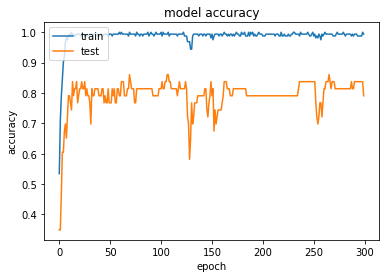

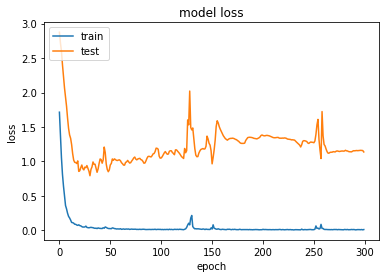

In [42]:
# graph

# summarize history for accuracy
plt.plot(gru_history.history['accuracy'])
plt.plot(gru_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(gru_history.history['loss'])
plt.plot(gru_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
loss, acc = model_gru.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 0s 58ms/step - loss: 1.1378 - accuracy: 0.7907

Test accuracy =  0.7906976938247681


In [44]:
model_gru.save('command_iden_model_final_gru.h5')

#### RNN Training

In [45]:
model_RNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
rnn_history = model_RNN.fit(X_train_indices, Y_train_oh, epochs = 300, batch_size = 25, shuffle=True,validation_data=(X_test_indices, Y_test_oh))

Epoch 1/300
7/7 [==============================] - 6s 249ms/step - loss: 3.4937 - accuracy: 0.0683 - val_loss: 3.3366 - val_accuracy: 0.0465
Epoch 2/300
7/7 [==============================] - 0s 55ms/step - loss: 3.2268 - accuracy: 0.0683 - val_loss: 3.3059 - val_accuracy: 0.0465
Epoch 3/300
7/7 [==============================] - 0s 65ms/step - loss: 3.1752 - accuracy: 0.0683 - val_loss: 3.2134 - val_accuracy: 0.0698
Epoch 4/300
7/7 [==============================] - 0s 59ms/step - loss: 3.1138 - accuracy: 0.0994 - val_loss: 3.1004 - val_accuracy: 0.0930
Epoch 5/300
7/7 [==============================] - 0s 59ms/step - loss: 2.8218 - accuracy: 0.1925 - val_loss: 3.1254 - val_accuracy: 0.0930
Epoch 6/300
7/7 [==============================] - 0s 62ms/step - loss: 2.7477 - accuracy: 0.1988 - val_loss: 3.1520 - val_accuracy: 0.0930
Epoch 7/300
7/7 [==============================] - 1s 67ms/step - loss: 2.5563 - accuracy: 0.2795 - val_loss: 3.1380 - val_accuracy: 0.1163
Epoch 8/300
7/7 [==

7/7 [==============================] - 0s 64ms/step - loss: 0.0421 - accuracy: 0.9938 - val_loss: 2.8148 - val_accuracy: 0.4884
Epoch 118/300
7/7 [==============================] - 0s 63ms/step - loss: 0.0357 - accuracy: 0.9938 - val_loss: 2.8456 - val_accuracy: 0.4884
Epoch 119/300
7/7 [==============================] - 0s 45ms/step - loss: 0.0247 - accuracy: 1.0000 - val_loss: 2.8972 - val_accuracy: 0.4419
Epoch 120/300
7/7 [==============================] - 0s 59ms/step - loss: 0.0359 - accuracy: 0.9876 - val_loss: 2.8928 - val_accuracy: 0.4419
Epoch 121/300
7/7 [==============================] - 0s 70ms/step - loss: 0.0315 - accuracy: 0.9876 - val_loss: 2.8332 - val_accuracy: 0.4884
Epoch 122/300
7/7 [==============================] - 0s 70ms/step - loss: 0.0476 - accuracy: 0.9876 - val_loss: 2.8588 - val_accuracy: 0.4884
Epoch 123/300
7/7 [==============================] - 0s 67ms/step - loss: 0.0364 - accuracy: 0.9938 - val_loss: 2.9885 - val_accuracy: 0.4419
Epoch 124/300
7/7 [=

Epoch 175/300
7/7 [==============================] - 0s 63ms/step - loss: 0.0217 - accuracy: 0.9938 - val_loss: 3.0920 - val_accuracy: 0.4651
Epoch 176/300
7/7 [==============================] - 0s 61ms/step - loss: 0.0327 - accuracy: 0.9938 - val_loss: 3.1245 - val_accuracy: 0.4884
Epoch 177/300
7/7 [==============================] - 0s 50ms/step - loss: 0.0376 - accuracy: 0.9938 - val_loss: 3.1326 - val_accuracy: 0.4419
Epoch 178/300
7/7 [==============================] - 0s 73ms/step - loss: 0.0219 - accuracy: 0.9938 - val_loss: 2.9435 - val_accuracy: 0.4419
Epoch 179/300
7/7 [==============================] - 0s 76ms/step - loss: 0.0241 - accuracy: 1.0000 - val_loss: 2.8845 - val_accuracy: 0.5116
Epoch 180/300
7/7 [==============================] - 1s 85ms/step - loss: 0.0300 - accuracy: 0.9876 - val_loss: 2.9090 - val_accuracy: 0.5116
Epoch 181/300
7/7 [==============================] - 0s 63ms/step - loss: 0.0249 - accuracy: 0.9876 - val_loss: 2.9103 - val_accuracy: 0.4651
Epoch 

Epoch 290/300
7/7 [==============================] - 0s 57ms/step - loss: 0.0160 - accuracy: 0.9938 - val_loss: 3.5369 - val_accuracy: 0.3488
Epoch 291/300
7/7 [==============================] - 0s 63ms/step - loss: 0.0189 - accuracy: 0.9876 - val_loss: 3.5382 - val_accuracy: 0.3488
Epoch 292/300
7/7 [==============================] - 0s 52ms/step - loss: 0.0154 - accuracy: 0.9876 - val_loss: 3.5599 - val_accuracy: 0.3488
Epoch 293/300
7/7 [==============================] - 0s 68ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 3.5804 - val_accuracy: 0.3488
Epoch 294/300
7/7 [==============================] - 0s 52ms/step - loss: 0.0114 - accuracy: 0.9938 - val_loss: 3.6073 - val_accuracy: 0.3488
Epoch 295/300
7/7 [==============================] - 0s 68ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 3.5946 - val_accuracy: 0.3488
Epoch 296/300
7/7 [==============================] - 0s 73ms/step - loss: 0.0163 - accuracy: 0.9876 - val_loss: 3.5780 - val_accuracy: 0.3488
Epoch 

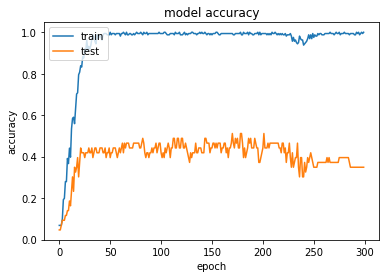

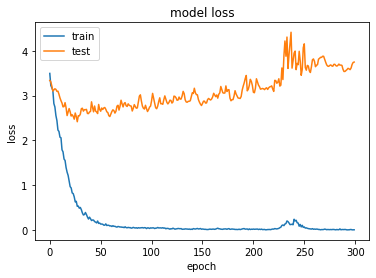

In [47]:
# graph

# summarize history for accuracy
plt.plot(rnn_history.history['accuracy'])
plt.plot(rnn_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(rnn_history.history['loss'])
plt.plot(rnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
loss, acc = model_RNN.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 0s 27ms/step - loss: 3.7467 - accuracy: 0.3488

Test accuracy =  0.3488371968269348



['accuracy', 'loss', 'val_accuracy', 'val_loss']


In [30]:
model_RNN.save('command_iden_model_final_rnn.h5')

## Test with your command.

In [57]:
sen = np.array(['lunch the most improtant thing'])
sen_idx = sentences_to_indices(sen,word_to_index,max_len = maxLen)


In [58]:
print(np.argmax(model.predict(sen_idx)))

15


In [59]:
# free res.

del model
del model_gru
del model_RNN
# del word_to_index
# del word_to_vec_map

## Let try to pruning the model

In [ ]:
model_prun = similarity_model((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 15, 200)           80000200  
_________________________________________________________________
hidden1 (LSTM)               (None, 15, 128)           168448    
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 128)           512       
_________________________________________________________________
dropout (Dropout)            (None, 15, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 15, 128)           131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 128)           512   

In [ ]:
model_prun.load_weights(pretrained_weights)  # loading pretrained weights 

In [ ]:
pip install -q tensorflow-model-optimization

     |████████████████████████████████| 215kB 6.7MB/s 


In [ ]:
import tensorflow_model_optimization as tfmot

**Lets try with pruning the whole model first**<br>
**Orignal model have the accuracy of 83 %**<br>
Lets see what we will get here..

In [ ]:
for layer in model_prun.layers:
  print(layer)

In [ ]:
# base_model = setup_model()
# pretrained_weights1 = setup_pretrained_weights()
# base_model.load_weights(pretrained_weights1)
# model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(base_model)

# model_for_pruning.summary()
# layer = []
# for i in model_prun.layers:
#   layer.append(i)

# def apply_pruning_to_layers(layer):
#   count = 0
#   if isinstance(layer, tf.keras.layers.LSTM):
#     count += 1
#     return tfmot.sparsity.keras.prune_low_magnitude(layer)
#   # elif isinstance(layer, tf.keras.layers.Dense):
#   #   count += 1
#   #   return tfmot.sparsity.keras.prune_low_magnitude(layer)
#   else:
#     print('failed')
#   print(count)
#   return layer

def apply_pruning_to_dense(layer):
  if isinstance(layer, tf.keras.layers.LSTM):
    print('yo')
    return tfmot.sparsity.keras.prune_low_magnitude(layer)
  return layer

model_for_pruning = tf.keras.models.clone_model(
    model_prun,
    clone_function=apply_pruning_to_dense)

# pruning the whole model
# model_for_pruning = prune.prune_low_magnitude(model_prun, pruning_schedule.PolynomialDecay(
#     initial_sparsity=0.3, final_sparsity=0.7, begin_step=1000, end_step=3000))

model_for_pruning.summary()


yo
yo
yo


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 15, 200)           80000200  
_________________________________________________________________
prune_low_magnitude_hidden1  (None, 15, 128)           336387    
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 128)           512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
prune_low_magnitude_lstm_2 ( (None, 15, 128)           262659    
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 128)           512 

In [ ]:
# compile
model_for_pruning.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
log_dir = tempfile.mkdtemp()
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    # Log sparsity and other metrics in Tensorboard.
    tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir)
]

In [ ]:
model_for_pruning.fit(X_train_indices, Y_train_oh, epochs = 1000, callbacks= callbacks, batch_size = 30, shuffle=True, validation_data=(X_test_indices, Y_test_oh))
model_for_pruning.reset_states()

Epoch 1/1000
6/6 [==============================] - 1s 148ms/step - loss: 0.0085 - accuracy: 0.9935 - val_loss: 1.3953 - val_accuracy: 0.7674
Epoch 2/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 1.3926 - val_accuracy: 0.7674
Epoch 3/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.0098 - accuracy: 0.9935 - val_loss: 1.3874 - val_accuracy: 0.7674
Epoch 4/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.0104 - accuracy: 0.9871 - val_loss: 1.3878 - val_accuracy: 0.7674
Epoch 5/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 1.3912 - val_accuracy: 0.7674
Epoch 6/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 1.3842 - val_accuracy: 0.7674
Epoch 7/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 1.3815 - val_accuracy: 0.7674
Epoch 8/1000

In [ ]:
loss, acc = model_for_pruning.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 0s 8ms/step - loss: 1.8891 - accuracy: 0.8140

Test accuracy =  0.8139534592628479


In [ ]:
sen = np.array(['I have to code. so setup my python environment'])
sen_idx = sentences_to_indices(sen,word_to_index,max_len = maxLen)
print(np.argmax(model_for_pruning.predict(sen_idx)))

20


In [ ]:
# save the pruned model
model_json = model_for_pruning.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("command_model_json.h5")

In [ ]:

with open('model.json','r') as f:
    json = f.read()
model2 = model_from_json(json)

model2.load_weights("/content/Keras-OpenFace/model/nn4.small2.channel_first.h5")

# Great Job Dude!!

# Test area

In [28]:
from tensorflow.keras.models import load_model,model_from_json
import nltk
import numpy as np

In [30]:
# loading general_model
ultimate_galvin_model = load_model('/content/drive/MyDrive/Datasets/Ultimate_Dude_Model.h5')

In [ ]:
loss, acc = ultimate_galvin_model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

**prerequisites for prediction**

In [ ]:
# Its a zip file so now to need to unzip it.
import zipfile

test_file_path = '/content/gdrive/MyDrive/Datasets/global-vectors-for-word-representation.zip'


with zipfile.ZipFile(test_file_path,"r") as zip_ref:
    zip_ref.extractall("/content/sample_data/datasets")

In [ ]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


In [ ]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/sample_data/datasets/glove.6B.200d.txt')

In [ ]:

inverse_vocabulary = ['<unk>'] 
tokenizer = nltk.tokenize.TreebankWordTokenizer()
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m,max_len))
    #print(X1_indices)
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words =tokenizer.tokenize(X[i])
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            try:
              X_indices[i, j] = word_to_index[w]
            except:
              continue
            # Increment j to j + 1
            j = j + 1
            
    ### END CODE HERE ###
    
    return X_indices

In [ ]:
maxLen = 15
test_sen = np.array(['hey whats your name dude'])
sen_idx = sentences_to_indices(test_sen,word_to_index,maxLen)

print(np.argmax(ultimate_galvin_model.predict(sen_idx)))

5


In [ ]:
import shutil

path = '/content/model_with_dense_prune.h5'
dest = '/content/drive/MyDrive/Datasets'
shutil.copy(path,dest)

FileNotFoundError: ignored

# That's it